<a href="https://colab.research.google.com/github/egbubemi/clinical_trials/blob/main/Analysis_clinicaltrial_2021_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
year = "2021"

fileroot = "clinicaltrial_" + year

In [ ]:
import os
os.environ ['fileroot'] = fileroot

In [ ]:
clinicaltrial_df = spark.read.options(delimiter ="|").csv("/FileStore/tables/" + fileroot +  ".csv/", header= "True", inferSchema=True)
clinicaltrial_df.show(5, truncate = False)

+-----------+--------------------------------------+----------------------+--------+----------+--------------------------------+----------+-------------------------------------------------+-------------+
|Id         |Sponsor                               |Status                |Start   |Completion|Type                            |Submission|Conditions                                       |Interventions|
+-----------+--------------------------------------+----------------------+--------+----------+--------------------------------+----------+-------------------------------------------------+-------------+
|NCT02758028|The University of Hong Kong           |Recruiting            |Aug 2005|Nov 2021  |Interventional                  |Apr 2016  |null                                             |null         |
|NCT02751957|Duke University                       |Completed             |Jul 2016|Jul 2020  |Interventional                  |Apr 2016  |Autistic Disorder,Autism Spectrum Disorder   

In [ ]:
clinicaltrial_df.toPandas()

,Id,Sponsor,Status,Start,Completion,Type,Submission,Conditions,Interventions
0,NCT02758028,The University of Hong Kong,Recruiting,Aug 2005,Nov 2021,Interventional,Apr 2016,None,None
1,NCT02751957,Duke University,Completed,Jul 2016,Jul 2020,Interventional,Apr 2016,"Autistic Disorder,Autism Spectrum Disorder",None
2,NCT02758483,Universidade Federal do Rio de Janeiro,Completed,Mar 2017,Jan 2018,Interventional,Apr 2016,Diabetes Mellitus,None
3,NCT02759848,Istanbul Medeniyet University,Completed,Jan 2012,Dec 2014,Observational,May 2016,"Tuberculosis,Lung Diseases,Pulmonary Disease",None
4,NCT02758860,University of Roma La Sapienza,"Active, not recruiting",Jun 2016,Sep 2020,Observational [Patient Registry],Apr 2016,"Diverticular Diseases,Diverticulum,Diverticulosis",None
...,...,...,...,...,...,...,...,...,...
387256,NCT04576611,University of the Balearic Islands,Completed,Mar 2019,Feb 2020,Interventional,Jul 2020,"Back Pain,Low Back Pain",None
387257,NCT04571138,Seattle Children's Hospital,Recruiting,Sep 2020,Feb 2038,Interventional,Sep 2020,"Lymphoma,Leukemia",None
387258,NCT04578847,"National Research Center for Hematology, Russia","Active, not recruiting",Jan 2020,Jan 2025,Interventional,Mar 2020,Leukemia,"Imatinib Mesylate,Dasatinib"
387259,NCT04577300,Stanford University,Recruiting,May 2021,Dec 2023,Interventional,Sep 2020,Glaucoma,None


<h5/> Question 1 <h/5>

In [ ]:

clinicaltrial_df.distinct().count()

Out[6]: 387261

<h5>  Question 2 
Types of Studies and Frequencies
<h5/>

In [ ]:
from pyspark.sql.functions import split, explode, count, desc

# this shows the frequency count of each type then order by descending frequency
studies_type = clinicaltrial_df.groupBy("Type").count().orderBy(desc("count"))

# display the results
studies_type.toPandas().head(5)


,Type,count
0,Interventional,301472
1,Observational,77540
2,Observational [Patient Registry],8180
3,Expanded Access,69


In [ ]:
studies_type.show()

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



<h5> Question 3 

Top 5 Conditions and Frequencies <h5/>

In [ ]:
from pyspark.sql.functions import split, explode, count, desc

# split conditions into an array and explode into separate rows
conditions_frequency = clinicaltrial_df.where(clinicaltrial_df['Conditions'].isNotNull()) \
                            .select(explode(split('Conditions', ',')).alias('condition'))

# count the frequency of each distinct condition and order by descending frequency
total_conditions_frequency = conditions_frequency.groupBy('condition').count().orderBy(desc('count'))

# show the top 5 conditions
total_conditions_frequency.toPandas().head(5)



,condition,count
0,Carcinoma,13389
1,Diabetes Mellitus,11080
2,Neoplasms,9371
3,Breast Neoplasms,8640
4,Syndrome,8032


In [ ]:
total_conditions_frequency.show(5)


+-----------------+-----+
|        condition|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+
only showing top 5 rows



<h5> Question 4: 
    
    Top 10 Sponsors That are not Pharmaceutical

In [ ]:
from pyspark.sql.types import *
Pharma_df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .option("delimiter", ",") \
    .csv("/FileStore/tables/pharma.csv")

In [ ]:
Pharma_df.toPandas().head(5)

,Company,Parent_Company,Penalty_Amount,Subtraction_From_Penalty,Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting,Penalty_Year,Penalty_Date,Offense_Group,Primary_Offense,Secondary_Offense,...,NAICS_Code,NAICS_Translation,HQ_Country_of_Parent,HQ_State_of_Parent,Ownership_Structure,Parent_Company_Stock_Ticker,Major_Industry_of_Parent,Specific_Industry_of_Parent,Info_Source,Notes
0,Abbott Laboratories,Abbott Laboratories,"$5,475,000",$0,"$5,475,000",2013,20131227,government-contracting-related offenses,False Claims Act and related,kickbacks and bribery,...,NaN,None,USA,Illinois,publicly traded,ABT,pharmaceuticals,pharmaceuticals,https://www.justice.gov/opa/pr/abbott-laborato...,None
1,Abbott Laboratories Inc.,AbbVie,"$1,500,000,000",$0,"$1,500,000,000",2012,20120507,healthcare-related offenses,off-label or unapproved promotion of medical p...,None,...,NaN,None,USA,Illinois,publicly traded,ABBV,pharmaceuticals,pharmaceuticals,http://www.justice.gov/opa/pr/abbott-labs-pay-...,None
2,Abbott Laboratories Inc.,AbbVie,"$126,500,000",$0,"$126,500,000",2010,20101207,government-contracting-related offenses,False Claims Act and related,None,...,NaN,None,USA,Illinois,publicly traded,ABBV,pharmaceuticals,pharmaceuticals,https://www.justice.gov/opa/pr/pharmaceutical-...,None
3,"Abbott Laboratories Puerto Rico, Inc.",Abbott Laboratories,"$49,045",$0,"$49,045",2009,20090305,employment-related offenses,wage and hour violation,Fair Labor Standards Act,...,423450.0,"423450: Medical, Dental, and Hospital Equipmen...",USA,Illinois,publicly traded,ABT,pharmaceuticals,pharmaceuticals,"March 7, 2017 download of a dataset posted by ...",Date and year are the Findings End Date in the...
4,Acclarent Inc.,Johnson & Johnson,"$18,000,000",$0,"$18,000,000",2016,20160722,government-contracting-related offenses,False Claims Act and related,None,...,NaN,None,USA,New Jersey,publicly traded,JNJ,pharmaceuticals,pharmaceuticals,https://www.justice.gov/opa/pr/johnson-johnson...,None


In [ ]:
# combining both clinical trials and pharma dataframe to create a new dataframe then bringing out the sponsors column
clinicaltrial_pharma_df = clinicaltrial_df.join(Pharma_df, clinicaltrial_df.Sponsor == Pharma_df.Parent_Company, "left_anti")

clinicaltrial_pharma_df.toPandas().head(7)


,Id,Sponsor,Status,Start,Completion,Type,Submission,Conditions,Interventions
0,NCT02758028,The University of Hong Kong,Recruiting,Aug 2005,Nov 2021,Interventional,Apr 2016,None,None
1,NCT02751957,Duke University,Completed,Jul 2016,Jul 2020,Interventional,Apr 2016,"Autistic Disorder,Autism Spectrum Disorder",None
2,NCT02758483,Universidade Federal do Rio de Janeiro,Completed,Mar 2017,Jan 2018,Interventional,Apr 2016,Diabetes Mellitus,None
3,NCT02759848,Istanbul Medeniyet University,Completed,Jan 2012,Dec 2014,Observational,May 2016,"Tuberculosis,Lung Diseases,Pulmonary Disease",None
4,NCT02758860,University of Roma La Sapienza,"Active, not recruiting",Jun 2016,Sep 2020,Observational [Patient Registry],Apr 2016,"Diverticular Diseases,Diverticulum,Diverticulosis",None
5,NCT02757209,Consorzio Futuro in Ricerca,Completed,Apr 2016,Jan 2018,Interventional,Apr 2016,Asthma,"Fluticasone,Xhance,Budesonide,Formoterol Fumar..."
6,NCT02752438,Ankara University,Unknown status,May 2016,Jul 2017,Observational [Patient Registry],Apr 2016,Hypoventilation,None


<h5> Question 4:
  
Top 10 sponsors that are not pharmaceutical company <h5/>

In [ ]:
#importing the necessary library and grouping by sponsor

from pyspark.sql.functions import split, explode, count, desc

top10_sponsor = clinicaltrial_pharma_df.groupBy('Sponsor').count().orderBy(desc('count'))

# show the top 5 conditions
top10_sponsor.limit(10).toPandas()

,Sponsor,count
0,National Cancer Institute (NCI),3218
1,M.D. Anderson Cancer Center,2414
2,Assistance Publique - Hôpitaux de Paris,2369
3,Mayo Clinic,2300
4,Merck Sharp & Dohme Corp.,2243
5,Assiut University,2154
6,Novartis Pharmaceuticals,2088
7,Massachusetts General Hospital,1971
8,Cairo University,1928
9,Hoffmann-La Roche,1828


<h5> Question 5:  Number of Completed Studies Each Month in a given year <h/5>

In [ ]:
from pyspark.sql.functions import col, to_date, date_format

completed_studies = clinicaltrial_df.select('Status', 'Completion')\
    .filter(col('Status') == "Completed")\
    .filter(col('Completion').contains(year))

#Convert Completion column to date format

completed_studies = completed_studies.withColumn("Completion", to_date(completed_studies["Completion"], "MMM yyyy"))

completed_studies = completed_studies.groupBy(col('Completion')).count().sort('Completion')

completed_studies = completed_studies.withColumn("Completion", date_format(completed_studies["Completion"], "MMM yyyy"))

completed_studies.toPandas()

,Completion,count
0,Jan 2021,1131
1,Feb 2021,934
2,Mar 2021,1227
3,Apr 2021,967
4,May 2021,984
5,Jun 2021,1094
6,Jul 2021,819
7,Aug 2021,700
8,Sep 2021,528
9,Oct 2021,187


<h5> further analysis <h/5>

<h5>  Find the number of pharmaceutical companies in each country, and the country with the highest number of companies <h/5>

In [ ]:
from pyspark.sql.functions import desc

# Checking for missing number in HQ_Country_of_Parent column Data cleaning on the HQ_country_of_parent column by checking missing number
Pharma_df.filter(Pharma_df.HQ_Country_of_Parent.isNull()).count()

# Drop missing number in HQ_Country_of_Parent column
Pharma_df_na = Pharma_df.dropna(subset=['HQ_Country_of_Parent'])

PharmaCom_in_countries = Pharma_df_na.groupBy("HQ_Country_of_Parent").agg(count("*").alias("No_of_Companies"))
PharmaCom_in_countries = PharmaCom_in_countries.orderBy(desc("No_of_Companies"))
PharmaCom_in_countries.show()


+--------------------+---------------+
|HQ_Country_of_Parent|No_of_Companies|
+--------------------+---------------+
|                 USA|            532|
|      United Kingdom|             69|
|             Ireland|             59|
|         Switzerland|             59|
|              Israel|             56|
|               Japan|             52|
|             Germany|             51|
|              France|             28|
|              Canada|             22|
|             Denmark|             14|
|               India|             12|
|             Belgium|              8|
|           Australia|              3|
+--------------------+---------------+



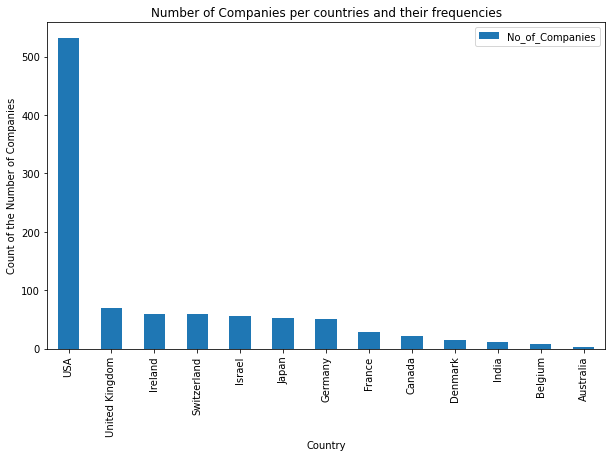

In [ ]:

# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import pandas as pd

# Convert result to Pandas DataFrame for plotting
Pharcom_Pandas = PharmaCom_in_countries.toPandas()

# Plot the result
Pharcom_Pandas.plot(kind='bar', x='HQ_Country_of_Parent', y='No_of_Companies', figsize=(10,6))
plt.title('Number of Companies per countries and their frequencies')
plt.xlabel('Country')
plt.ylabel('Count of the Number of Companies')
plt.show()